### Distance Metrics

#### 1. Motivation

정보 이론, 특히 Shannon's entropy 개념은 금융에 유용한 응용 분야를 갖고 있다. 엔트로피의 핵심 아이디어는 랜덤 변수와 관련된 불확실성의 양을 계량화하는 것이다. 많은 머신러닝 알고리즘의 1차 목표는 문제 해결과 관련된 불확실성의 양을 줄이는 것이기 때문에 정보 이론은 머신러닝에 필수적이다

#### 2. A Correlation-Based Metric

상관계수는 선형적 상호의존성의 유용한 척도이다. 일단 상관계수 행렬의 잡음과 주음이 제거되면 시스템에 대한 중요한 구조 정보를 보일 수 있다. 예를 들어, 상호연관성이 매우 높은 유가증권의 군집을 식별하고자 상관계수를 사용할 수 있다

그러나, 상관계수를 사용하기 전에 기술적 문제를 해결해야 한다. 상관계수는 비음성과 삼각 부등식 조건을 충족시키지 못하기 때문에 척도가 되지 못한다. 거리 척도는 집합에 대한 직관적인 위상관계를 유도하기 때문에 중요하다. 이러한 직관적 위상관계 없이 상호의존성의 비거리적 측정을 비교하는 것은 다소 일관성 없는 결과를 초래할 수 있다

크기 T의 랜덤 벡터 $X$와 $Y$와 상관계수 추정치 $\rho(X,Y)$를 고려하자. 상관계수는 단지 $\sigma(X,Y) = \rho(X,Y)\sigma(X)\sigma(Y)$만을 만족하면 된다. 피어슨 상관계수는 이들 조건을 만족하는 여러 상관계수 추정치 중 하나이다. 이때 $d_\rho(X,Y) = \sqrt{1/2(1 - \rho(X,Y))}$는 거리 척도이다

거리 척도 $d(X, Y)$는 $\rho(X,Y) \in [-1, 1]$이므로 정규화 특성 $d_p(X,Y) \in [0,1]$을 갖는다. 또 다른 특성은 절대값에 상관없이 음의 상관계수를 갖는 두 랜덤 변수가 양의 상관계수를 갖는 두 랜덤변수보다 더 멀게 된다는 것이다. 이 특성은 여러 응용에서 합리적이다. 예를 들어, long only portfolio를 구축하고자 할 때, 음의 상관계수를 갖는 보유 종목들은 단지 위험만을 상쇄하므로 분산 목적을 위해 다르게 취급해야만 한다

다른 예로, long-short portfolio를 들 수 있는데 종종 매우 큰 음의 상관계수를 가진 증권을 유사하게 고려한다. 이 경우 대안적인 정규화된 상관계수 기반의 거리 척도 $d_{|\rho|}(X,Y) = \sqrt{1 - |\rho(X,Y)|}$를 정의할 수 있다

마찬가지로 $d_{|\rho|}$가 $Z/2Z$비율에 대한 진정한 척도로 축약되는 것 또한 보일 수 있다

$$d(x,y) = \sqrt{2T(1 - \rho(x,y)} = \sqrt{2T}d_{|\rho|}(X,Y)$$

In [1]:
import pandas_datareader as web
start_date = '2019-09-01'
end_date = '2023-08-31'

kodex_etf = '069500' # KODEX 200
kospi200_etf = '069660'  # kiwoom KOSEF KOSPI 200
kosdaq150_etf = '316670'  # kiwoom KOSDAQ 150
samsung_code = '005930'  # Samsung
lg_code = '066570'  # LG
posco_code = '005490'  # POSCO

kodex = web.DataReader(kodex_etf, 'naver', start = start_date, end = end_date).astype(float).Close
kospi = web.DataReader(kospi200_etf, 'naver', start = start_date, end = end_date).astype(float).Close
kosdaq = web.DataReader(kosdaq150_etf, 'naver', start = start_date, end = end_date).astype(float).Close
samsung = web.DataReader(samsung_code, 'naver', start = start_date, end = end_date).astype(float).Close
lg = web.DataReader(lg_code, 'naver', start = start_date, end = end_date).astype(float).Close
posco = web.DataReader(posco_code, 'naver', start = start_date, end = end_date).astype(float).Close

In [2]:
import numpy as np
import pandas as pd

kodex_ret = np.log(kodex/kodex.shift(1)).dropna()
kospi_ret = np.log(kospi/kospi.shift(1)).dropna()
kosdaq_ret = np.log(kosdaq/kosdaq.shift(1)).dropna()
samsung_ret = np.log(samsung/samsung.shift(1)).dropna()
lg_ret = np.log(lg/lg.shift(1)).dropna()
posco_ret = np.log(posco/posco.shift(1)).dropna()
matrix = pd.concat([kodex_ret, kospi_ret, kosdaq_ret, samsung_ret, lg_ret, posco_ret], axis = 1)
matrix.columns = ['KODEX','KOSPI','KOSDAQ','Samsung','LG','Posco']

In [3]:
matrix.corr()

,KODEX,KOSPI,KOSDAQ,Samsung,LG,Posco
KODEX,1.000000,0.997688,0.739605,0.857523,0.526906,0.531335
KOSPI,0.997688,1.000000,0.736628,0.858682,0.526988,0.529572
KOSDAQ,0.739605,0.736628,1.000000,0.527195,0.372688,0.392824
Samsung,0.857523,0.858682,0.527195,1.000000,0.396507,0.379009
LG,0.526906,0.526988,0.372688,0.396507,1.000000,0.272036
Posco,0.531335,0.529572,0.392824,0.379009,0.272036,1.000000


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from RandomMatrixWithSignal import cov2corr, getRndCov
from MarcenkoPastur import getPCA
from FittingMarcenkoPastur import findMaxEval
from ConstantResidual import denoisedCorr, denoisedCorr2

alpha, nCols, nFact, q = 0.995, 6, 100, 10

cov = alpha * matrix.cov() + (1-alpha) * getRndCov(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Denoising with Constant residual eigenvalue method')

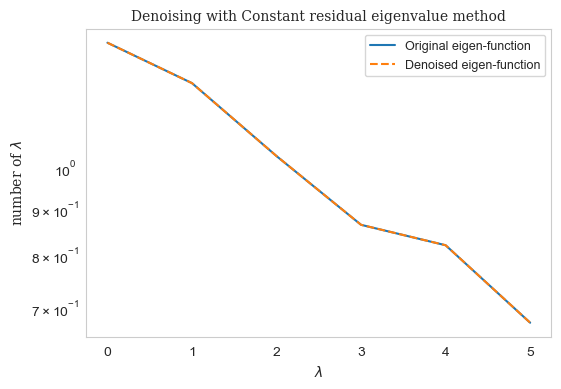

In [5]:
plt.figure(figsize = (6,4))
plt.grid(False)
plt.plot(eigenvalue_prior, label = 'Original eigen-function')
plt.plot(denoised_eigenvalue, label = 'Denoised eigen-function', ls = '--')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontfamily='Serif')
plt.ylabel(r'number of $\lambda$', fontfamily='Serif')
plt.legend(loc='upper right', fontsize=9)
plt.title('Denoising with Constant residual eigenvalue method', fontsize=10, fontfamily='Serif')

In [6]:
matrix_denoised = pd.DataFrame(eVec1, columns = matrix.columns, index = matrix.columns)
matrix_denoised

,KODEX,KOSPI,KOSDAQ,Samsung,LG,Posco
KODEX,-0.566911,0.180027,-0.240252,0.321939,0.540438,-0.439048
KOSPI,0.480006,0.189418,-0.194296,0.827259,-0.085422,0.065646
KOSDAQ,-0.002388,0.704065,0.159625,-0.133459,-0.478170,-0.482025
Samsung,-0.250679,-0.608820,0.225499,0.320362,-0.489266,-0.416696
LG,0.298621,-0.002308,0.808422,0.080744,0.454450,-0.210308
Posco,-0.544230,0.255609,0.417914,0.291606,-0.161483,0.593897


In [7]:
def corrBasedMetric(corr : pd.DataFrame) -> pd.DataFrame :
    T = len(corr.iloc[:,0])
    result = np.sqrt(2 * T *(1 - np.abs(corr)))
    return result

In [8]:
corrBasedMetric(matrix_denoised)

,KODEX,KOSPI,KOSDAQ,Samsung,LG,Posco
KODEX,2.279709,3.136825,3.019432,2.852496,2.348349,2.594498
KOSPI,2.497986,3.118811,3.109413,1.439753,3.312844,3.348469
KOSDAQ,3.459964,1.884467,3.175609,3.224669,2.502392,2.493130
Samsung,2.998642,2.166602,3.048608,2.855810,2.475642,2.645685
LG,2.901128,3.460102,1.516226,3.321305,2.558631,3.078360
Posco,2.338640,2.988761,2.642921,2.915600,3.172097,2.207540


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'A Correlation based metric')

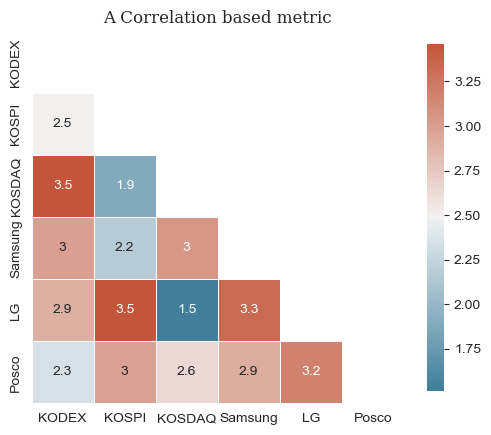

In [9]:
import seaborn as sns
mask = np.triu(np.ones_like(matrix.cov(), dtype = bool))
f, ax = plt.subplots(figsize = (6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(False)
sns.heatmap(corrBasedMetric(matrix_denoised), mask = mask, cmap = cmap,
            square = True, linewidths = .5, cbar_kws = {"shrink": .9}, annot = True)
plt.title('A Correlation based metric', fontsize = 12, fontfamily = 'Serif')

#### 3. Marginal and Joint Entropy

상관계수 개념은 세 가지 중요한 결점을 제공한다.
1. 이는 두 랜덤 변수 간의 선형 상호의존성을 계량화한다. 이는 비선형관계를 무시한다
2. 상관계수는 특이치에 크게 영향을 받는다
3. 다변수 정규 분포의 경우를 넘어서는 응용은 의심스럽다

어떤 두 실수 변수간의 상관관계를 포착하고 싶지만, 두 변수가 이변수 정규 분포를 따르지 않는다면 상관계수는 일반적으로 의미가 없어진다. 이러한 결함을 극복하고자 몇 가지 정보이론 개념을 도입해야 한다

$X$를 확률 $p(x)$로 집합 $S_X$로부터 $x$값을 취하는 이산 랜덤 변수라 하자. $X$의 엔트로피는 다음과 같이 정의된다

$$H(X) = -\sum_{x \in S_X}p(x)\log p(x)$$

대부분의 경우, Entropy는 단일변수가 아닌 이변수 이상을 고려할 것이다. $Y$를 확률 $p(y)$로 집합 $S_Y$로부터 $y$값을 취하는 이산 랜덤 변수라 하자. 랜덤 변수 $X$와 $Y$는 동일한 확률 공간에서 정의돌 필요는 없다. $X$와 $Y$의 Joint entropy는 다음과 같다

$$H(X,Y) = -\sum_{x,y \in S_X \times S_Y}p(x,y) \log p(x,y)$$

특히 $H(X,Y) = H(Y,X), H(X,X) = H(X), H(X,Y) \geq \max[H(X),H(Y)]$이고, $H(X,Y) \leq H(X) + H(Y)$이다

Shannon의 엔트로피는 단지 이산 랜덤 변수에 대해서만 유한하다는 것을 인지하는 것이 중요하다. 연속인 경우 이산 포인트의 Limiting Density of Discrete Point를 사용하거나 랜덤 변수를 이산화해야 한다

#### 4. Conditional entropy

$Y$가 주어졌을 때 $X$의 Conditional entropy는 다음과 같이 정의된다

$$H(X|Y) = H(X,Y) - H(Y) = -\sum_{y \in S_Y}p(y)\sum_{x \in S_X}p(x|Y=y) \log p(x|Y = y)$$

여기서 $p(x |Y=y)$는 $Y$가 $y$값을 취할 때 조건부로 $X$가 $x$값을 취하는 확률이다. 이 정의를 따라서 $H(X|Y)$는 $Y$의 값을 들었을 때 $X$에서 기대하는 불확실성이다. 따라서 $H(X|Y)=0$이고, $H(X) \geq H(X|Y)$이다

#### 5. Kullback–Leibler Divergence

$p$와 $q$가 동일한 확률 공간에 정의된 2개의 이산 확률 분포라고 하자. $p$와 $q$간의 Kullback Leibler 발산은 다음과 같다

$$D_{KL}[p||q] = -\sum_{x \in S_X}p(x) \log \Big[\frac{q(x)}{p(x)}\Big] = \sum_{x \in S_X}p(x) \log \Big[\frac{p(x)}{q(x)} \Big]$$

여기서 $q(x) = 0 \Rightarrow p(x) = 0$이다. 직관적으로 이 표현은 $p$가 얼마나 기준 분포 $q$로부터 발산하는가를 측정한다. KL발산은 거리 척도가 아니다. 항상 비음이지만, 대칭성과 삼각 부등 조건을 위배한다. 두 랜덤 변수가 반드시 동일한 확률 공간에 존재할 필요가 없는 결합 엔트로피의 정의와의 차이를 주목하자. KL발산은 Variational Inference에 널리 사용된다

#### 6. Cross entropy

$p$와 $q$를 동일한 확률 공간에 정의된 2개의 이산 확률 분포라 하자. $p$와 $q$간의 교차 엔트로피는 다음과 같다

$$H_C[p||q] = -\sum_{x \in S_X}p(x) \log q(x) = H(X) + D_{KL}[p||q]$$

교차 엔트로피는 진정한 분포 $p$가 아닌 잘못된 분포 $q$를 사용해서 정보 내용을 평가할 때의 $X$와 연관된 불확실성으로 해석될 수 있다. 교차 엔트로피는 분류 문제에 있어 인기 높은 점수 함수이며, 특히 금융 응용에 유용하다

#### 7. Mutual Information

상호 정보는 Y 값을 알 때 초래되는 X의 불확실성 감소로 정의된다

$$I(X,Y) = H(X) - H(X|Y) = H(X) + H(Y) - H(X,Y) = \sum_{x \in S_X}\sum_{y \in S_Y}p(x,y) \log\Big[\frac{p(x,y)}{p(x)p(y)}\Big]$$
$$= D_{KL}[p(x,y) || p(x)p(y)] = \sum_{y \in S_Y}p(y) \sum_{x \in S_X}p(x|y) \log \Big[\frac{p(x|y)}{p(x)}\Big]$$
$$= E_Y[D_{KL}[p(x|y)||p(x)]] = \sum_{x \in S_X} p(x) \sum_{y \in S_Y} p(y|x) \log \Big[ \frac{p(y|x)}{p(y)}\Big]$$
$$= E_X[D_{KL}[p(y|x)||p(y)]]$$

In [10]:
import numpy as np,scipy.stats as ss
from sklearn.metrics import mutual_info_score 

def numBins(nObs,corr=None):
    if corr is None: # univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3) 
    else: # bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5) 
    return int(b)
def varInfo(x,y,norm=False):
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1]) 
    cXY=np.histogram2d(x,y,bXY)[0] 
    iXY=mutual_info_score(None,None,contingency=cXY) 
    hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal 
    hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal 
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

In [11]:
bins = numBins(len(kospi_ret))

In [12]:
cXY=np.histogram2d(kospi_ret, kosdaq_ret)[0] 
hX=ss.entropy(np.histogram(kospi_ret,bins)[0]) # marginal 
hY=ss.entropy(np.histogram(kosdaq_ret,bins)[0]) # marginal 
iXY=mutual_info_score(None,None,contingency=cXY) 
iXYn=iXY/min(hX,hY) # normalized mutual information 
hXY=hX+hY-iXY # joint
hX_Y=hXY-hY # conditional
hY_X=hXY-hX # conditional

In [13]:
print(iXYn, hXY,hX_Y,hY_X)

0.19498746922436908 2.9826634803915493 1.2222297215750337 1.4643893233453065
